# Representation Learning and Property Matching for Thermodynamic Systems

Learn a representation of a thermodynamic system by training a system classifier and use the learned thermodynamic space for property (temperature, ferromagnetic/antiferromagnetic) learning

## Table of Contents

* [1. Data Processing](#1.-Data-Processing)
* [2. Representation Learning](#2.-Representation-Learning)
* [3. Learning and Predicting System Properties](#3.-Learning-and-Predicting-System-Properties)

In [1]:
%matplotlib inline

# basic libraries
import os, sys
import re
import copy
import glob
from itertools import product, combinations
import pickle
from collections import Counter

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from cycler import cycler

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, ReLU, Softmax
from tensorflow.keras.layers import Lambda, Embedding, LeakyReLU, Conv2D, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# local library for data processing
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_lattice_ising
from statmechlib.preprocessing import Trajectory

In [3]:
# Test gpu availability
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Some plotting functions

In [312]:
def plot_ternary(data, labels, classes = None, class_names = None, size=10, plt_title = None, legend_title = None):
    
    color = plt.cm.viridis(np.linspace(0, 1, len(classes)))
    mpl.rcParams['axes.prop_cycle'] = cycler(color=color)
    
    if legend_title is None:
        legend_title = "System, Temperature"

    # If no classes selected, get all
    if classes is None:
        classes = np.unique(labels)

    triplets = list(combinations(range(data.shape[1]), 3))

    colswitch = {1: 1, 2: 2, 3: 2, 4: 2}
    
    with plt.style.context(('seaborn-white')):
        size_ax = size
        size_x = size_ax
        size_y = size*0.75**0.5
        
        ncols = colswitch.get(len(triplets), 3)
        nrows = 1 + (len(triplets)-1)//ncols
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size_x*ncols, size_y*nrows))
        if plt_title is not None:
            fig.suptitle(plt_title, fontsize = 20)
            
        axes = np.ravel(axes)
        
        for ia, (i, j, k) in enumerate(triplets):
            # Make frame (always same)
            frame_x = np.array([0.0, 0.5*size_x/size, size_x/size])
            frame_y = np.array([0.0, size_y/size, 0.0])
            frame_triangle = np.array([[0, 1, 2]])
            frame_triang = tri.Triangulation(frame_x, frame_y, frame_triangle)

            axes[ia].triplot(frame_triang, 'k-')
            axes[ia].plot([frame_x[1], frame_x[1]], [frame_y[1]/3, 0.0], 'k--')
            axes[ia].plot([frame_x[1], frame_x[1]/2], [frame_y[1]/3, frame_y[1]/2], 'k--')
            axes[ia].plot([frame_x[1], (frame_x[1]+frame_x[2])/2], [frame_y[1]/3, (frame_y[1]+frame_y[2])/2], 'k--')
            axes[ia].axis('off')
        
            # translate the data to cartesian coords for each projection
            axes[ia].set_title(f'Projection: {i}-{j}-{k}', fontsize='xx-large')
            for cl in classes:
                idx = np.where(labels == cl)
                a = data[idx, i]
                b = data[idx, j]
                c = data[idx, k]
                x = 0.5 * ( 2.*b+c ) / ( a+b+c )*1
                y = 0.5*np.sqrt(3) * c / (a+b+c)*1
                axes[ia].scatter(x, y, s = 1, label = f'{class_names[cl]}')
            lgnd = axes[ia].legend(fontsize='x-large',
                                   title=legend_title, title_fontsize='x-large',
                                   handletextpad=0.1)
            for handle in lgnd.legendHandles:
                handle.set_sizes([40.0])

        # erase unused subplots
        for ia in range(len(triplets), nrows*ncols):
            axes[ia].axis('off')

In [275]:
def plot_ternary_continuum(data, labels, size=10, plt_title = None, legend_title = None):
    
    #color = plt.cm.viridis(np.linspace(0, 1, len(classes)))
    #mpl.rcParams['axes.prop_cycle'] = cycler(color=color)
    #mpl.rcParams['axes.prop_cycle'] = cycler(color='bg')
    
    if legend_title is None:
        legend_title = "System, Temperature"

    triplets = list(combinations(range(data.shape[1]), 3))

    colswitch = {1: 1, 2: 2, 3: 2, 4: 2}
    
    with plt.style.context(('seaborn-white')):
        size_ax = size
        size_x = size_ax
        size_y = size*0.75**0.5
        
        ncols = colswitch.get(len(triplets), 3)
        nrows = 1 + (len(triplets)-1)//ncols
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size_x*ncols, size_y*nrows))
        
        if plt_title is not None:
            fig.suptitle(plt_title, fontsize = 20)

        axes = np.ravel(axes)
        
        for ia, (i, j, k) in enumerate(triplets):
            # Make frame (always same)
            frame_x = np.array([0.0, 0.5*size_x/size, size_x/size])
            frame_y = np.array([0.0, size_y/size, 0.0])
            frame_triangle = np.array([[0, 1, 2]])
            frame_triang = tri.Triangulation(frame_x, frame_y, frame_triangle)

            axes[ia].triplot(frame_triang, 'k-')
            axes[ia].plot([frame_x[1], frame_x[1]], [frame_y[1]/3, 0.0], 'k--')
            axes[ia].plot([frame_x[1], frame_x[1]/2], [frame_y[1]/3, frame_y[1]/2], 'k--')
            axes[ia].plot([frame_x[1], (frame_x[1]+frame_x[2])/2], [frame_y[1]/3, (frame_y[1]+frame_y[2])/2], 'k--')
            axes[ia].axis('off')
        
            # translate the data to cartesian coords for each projection
            axes[ia].set_title(f'Projection: {i}-{j}-{k}', fontsize='xx-large')

            a = data[:, i]
            b = data[:, j]
            c = data[:, k]
            x = 0.5 * ( 2.*b+c ) / ( a+b+c )*1
            y = 0.5*np.sqrt(3) * c / (a+b+c)*1
            axes[ia].scatter(x, y, c=labels, cmap='RdYlBu',s = 1)

        # erase unused subplots
        for ia in range(len(triplets), nrows*ncols):
            axes[ia].axis('off')

## 1. Data Processing

### Load data from MC simulations

In [5]:
sim_dir = '../sim/mini'
temps = ['t1', 't2', 't5', 't10', 't20', 't100']  # ferromagnetic
temps.extend(['a100', 'a20', 'a10', 'a5', 'a2', 'a1'])  # antiferromagnetic

In [6]:
trjs = {}
for t in temps:
    #print(t)
    traj = read_lattice_ising(os.path.join(sim_dir, t))
    trjs[t] = Trajectory(traj)
    trjs[t] = trjs[t][1:]

print(trjs.keys())
print(len(trjs['t1']['energy']))

dict_keys(['t1', 't2', 't5', 't10', 't20', 't100', 'a100', 'a20', 'a10', 'a5', 'a2', 'a1'])
1000


In [7]:
cfgs = {}
cfgs_pad = {}
for key, trj in trjs.items():
    cfgs[key] = []
    cfgs_pad[key] = []
    for t_cfg, xyz_cfg in zip(trj['atom_type'], trj['xyz_latt']): 
        cfg = np.empty((15, 15), dtype=float)
        for t, (i, j, k) in zip(t_cfg, xyz_cfg):
            cfg[i-1, j-1] = 0.5*(t+1)
        cfgs[key].append(cfg)
        cfgs_pad[key].append(np.pad(cfg, pad_width=((1,1), (1,1)), mode='wrap'))

## Examples of configurations for ferromagnetic (t) and antiferromagnetic (a) Ising models at different reduced temperatures (1 - 100)

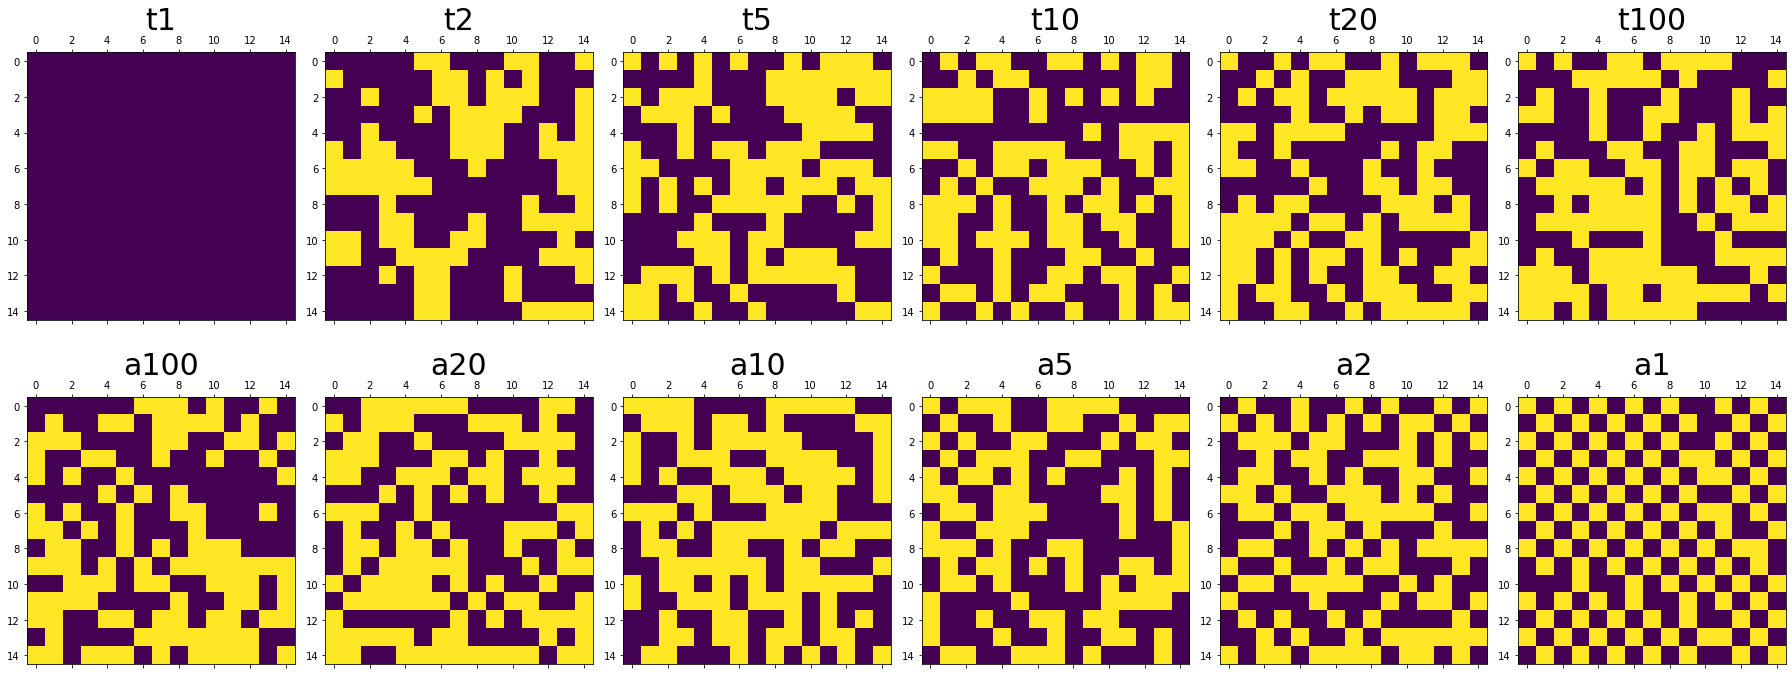

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(25,10))
axs = axs.flatten()
for i, t in enumerate(temps):
    axs[i].set_title(t, fontsize=30)
    axs[i].matshow(cfgs[t][200])

fig.tight_layout()

In [315]:
# Input image dimensions
img_rows, img_cols = cfgs['t1'][0].shape
channels = 1
img_shape = (img_rows, img_cols, channels)

# Dimensions of the embedding space
z_dim = 3

print('Input image shape: ', img_shape)
print('Feature space dimension: ', z_dim)

Input image shape:  (15, 15, 1)
Feature space dimension:  3


## 2. Representation Learning

Discriminate between different Ising systems by embedding each system into a probability space and optimizing classification in this space. Another (better) option is to maximize between-class/within-class variance ratio (as in Fisher/Linear Discriminant Analysis). This would directly optimize statistical distances.

### 2.1 Model definitions

In [11]:
def build_embedding(img_shape, ndim):
    """Model to embed 2D Ising configurations into an ndim-dimensional probability space.
    
    Collect local configurations from 3x3 windows, convert them into n-dimensional features,
    and convert those into a probability vector using average pooling over the whole
    configuration. 
    
    Arguments
    ---------
    img_shape: tuple
        Shape of the input data
    ndim: int
        Embedding dimension
    """

    model = Sequential()
    # Convolutional layer, from 15x15x1 into 7x7x8 tensor
    model.add(Conv2D(8, kernel_size=3, strides=2, input_shape=img_shape, padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(ndim, kernel_size=1, strides=1, padding='valid'))
    model.add(Softmax())
    model.add(Lambda(lambda x: tf.math.sqrt(x)))
    model.add(GlobalAveragePooling2D())  # Create a unit vector for the whole configuration

    return model

In [12]:
def build_classifier(nclass):
    """Model to embed 2D Ising configurations into an ndim-dimensional probability space.
    Collect local configurations from 3x3 windows, convert them into n-dimensional features,
    and convert those into a probability vector using average pooling over the whole
    configuration. 
    
    Arguments
    ---------
    nclass: int
        Number of classes
    """

    model = Sequential()
    model.add(Dense(nclass))
    model.add(Softmax())
    
    return model

In [13]:
def build_discriminator(mdl_embed, mdl_class):
 
    # Build a complete model
    model = Sequential()
    model.add(mdl_embed)
    model.add(mdl_class)
    
    return model

### 2.2 Training data preparation

In [14]:
# Set up training data
data_list = [np.expand_dims(np.array(cfgs[t][:]), axis=-1) for t in temps]#["t1", "t100", "a1"]]
data_train = np.concatenate(data_list, axis=0)
data_train.shape

(12000, 15, 15, 1)

In [15]:
# Set up labels
#data_out = np.concatenate([mm(dat) for dat in data_list], axis=0)
class_list = [np.array(len(cfg)*[i]) for i, cfg in enumerate(data_list)]
labels = np.concatenate(class_list, axis=0)
labels.shape

(12000,)

### 2.3 Model building, compiling, and training

In [16]:
# Build embedding
mdl_embed = build_embedding(img_shape, ndim=3)

# Build classification layers on top of embedding to train the embedder
mdl_class = build_classifier(nclass=len(np.unique(labels)))

# Connect embedding and classification for representation learning
mdl_train = build_discriminator(mdl_embed, mdl_class)

In [17]:
mdl_train.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'], optimizer=Adam())

In [18]:
history = mdl_train.fit(data_train, labels, epochs=1000, verbose=0)

Epoch 1/1000
375/375 [==============================] - 2s 2ms/step - loss: 2.5140 - accuracy: 0.0850
Epoch 2/1000
375/375 [==============================] - 1s 2ms/step - loss: 2.4719 - accuracy: 0.1217
Epoch 3/1000
375/375 [==============================] - 1s 3ms/step - loss: 2.4270 - accuracy: 0.2030
Epoch 4/1000
375/375 [==============================] - 1s 3ms/step - loss: 2.3568 - accuracy: 0.2694
Epoch 5/1000
375/375 [==============================] - 1s 2ms/step - loss: 2.2712 - accuracy: 0.2781
Epoch 6/1000
375/375 [==============================] - 1s 2ms/step - loss: 2.1934 - accuracy: 0.3018
Epoch 7/1000
375/375 [==============================] - 1s 2ms/step - loss: 2.1228 - accuracy: 0.3092
Epoch 8/1000
375/375 [==============================] - 1s 2ms/step - loss: 2.0639 - accuracy: 0.3347
Epoch 9/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.9997 - accuracy: 0.3435
Epoch 10/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.967

375/375 [==============================] - 1s 2ms/step - loss: 1.3106 - accuracy: 0.5163
Epoch 81/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.2979 - accuracy: 0.5247
Epoch 82/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.2977 - accuracy: 0.5295
Epoch 83/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.2908 - accuracy: 0.5274
Epoch 84/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.2930 - accuracy: 0.5295
Epoch 85/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.2869 - accuracy: 0.5254
Epoch 86/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.2876 - accuracy: 0.5272
Epoch 87/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.2875 - accuracy: 0.5260
Epoch 88/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.2823 - accuracy: 0.5327
Epoch 89/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.2807 - a

375/375 [==============================] - 0s 1ms/step - loss: 1.1781 - accuracy: 0.5464
Epoch 159/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.2001 - accuracy: 0.5356
Epoch 160/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1884 - accuracy: 0.5409
Epoch 161/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.1926 - accuracy: 0.5362
Epoch 162/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.1828 - accuracy: 0.5430
Epoch 163/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.1932 - accuracy: 0.5382
Epoch 164/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.1865 - accuracy: 0.5359
Epoch 165/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.1934 - accuracy: 0.5359
Epoch 166/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.1811 - accuracy: 0.5464
Epoch 167/1000
375/375 [==============================] - 0s 1ms/step - loss: 1

375/375 [==============================] - 1s 2ms/step - loss: 1.1539 - accuracy: 0.5428
Epoch 237/1000
375/375 [==============================] - 1s 3ms/step - loss: 1.1618 - accuracy: 0.5359
Epoch 238/1000
375/375 [==============================] - 1s 3ms/step - loss: 1.1487 - accuracy: 0.5483
Epoch 239/1000
375/375 [==============================] - 1s 3ms/step - loss: 1.1462 - accuracy: 0.5470
Epoch 240/1000
375/375 [==============================] - 1s 3ms/step - loss: 1.1621 - accuracy: 0.5329
Epoch 241/1000
375/375 [==============================] - 1s 3ms/step - loss: 1.1500 - accuracy: 0.5517
Epoch 242/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1596 - accuracy: 0.5458
Epoch 243/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1531 - accuracy: 0.5477
Epoch 244/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1381 - accuracy: 0.5471
Epoch 245/1000
375/375 [==============================] - 1s 3ms/step - loss: 1

375/375 [==============================] - 1s 2ms/step - loss: 1.1281 - accuracy: 0.5516
Epoch 315/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.1304 - accuracy: 0.5470
Epoch 316/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1290 - accuracy: 0.5485
Epoch 317/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1216 - accuracy: 0.5551
Epoch 318/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1239 - accuracy: 0.5501
Epoch 319/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1250 - accuracy: 0.5497
Epoch 320/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.1301 - accuracy: 0.5428
Epoch 321/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1395 - accuracy: 0.5439
Epoch 322/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1266 - accuracy: 0.5477
Epoch 323/1000
375/375 [==============================] - 0s 1ms/step - loss: 1

375/375 [==============================] - 1s 2ms/step - loss: 1.1047 - accuracy: 0.5514
Epoch 393/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1209 - accuracy: 0.5441
Epoch 394/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1164 - accuracy: 0.5534
Epoch 395/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0996 - accuracy: 0.5550
Epoch 396/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1162 - accuracy: 0.5507
Epoch 397/1000
375/375 [==============================] - 1s 3ms/step - loss: 1.1055 - accuracy: 0.5521
Epoch 398/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1067 - accuracy: 0.5554
Epoch 399/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1220 - accuracy: 0.5380
Epoch 400/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1249 - accuracy: 0.5434
Epoch 401/1000
375/375 [==============================] - 1s 2ms/step - loss: 1

375/375 [==============================] - 0s 1ms/step - loss: 1.1136 - accuracy: 0.5495
Epoch 471/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.0993 - accuracy: 0.5529
Epoch 472/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.1074 - accuracy: 0.5414
Epoch 473/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.1092 - accuracy: 0.5499
Epoch 474/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.0948 - accuracy: 0.5549
Epoch 475/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.1183 - accuracy: 0.5461
Epoch 476/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.1028 - accuracy: 0.5519
Epoch 477/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.0895 - accuracy: 0.5561
Epoch 478/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.1055 - accuracy: 0.5511
Epoch 479/1000
375/375 [==============================] - 1s 2ms/step - loss: 1

375/375 [==============================] - 0s 1ms/step - loss: 1.0977 - accuracy: 0.5534
Epoch 549/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0989 - accuracy: 0.5519
Epoch 550/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.0951 - accuracy: 0.5506
Epoch 551/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.0942 - accuracy: 0.5508
Epoch 552/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1030 - accuracy: 0.5465
Epoch 553/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.0907 - accuracy: 0.5564
Epoch 554/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.0902 - accuracy: 0.5566
Epoch 555/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.1034 - accuracy: 0.5532
Epoch 556/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0786 - accuracy: 0.5625
Epoch 557/1000
375/375 [==============================] - 1s 2ms/step - loss: 1

375/375 [==============================] - 1s 3ms/step - loss: 1.0837 - accuracy: 0.5609
Epoch 627/1000
375/375 [==============================] - 1s 3ms/step - loss: 1.0920 - accuracy: 0.5487
Epoch 628/1000
375/375 [==============================] - 1s 3ms/step - loss: 1.0859 - accuracy: 0.5569
Epoch 629/1000
375/375 [==============================] - 1s 3ms/step - loss: 1.0752 - accuracy: 0.5566
Epoch 630/1000
375/375 [==============================] - 1s 3ms/step - loss: 1.0821 - accuracy: 0.5597
Epoch 631/1000
375/375 [==============================] - 1s 3ms/step - loss: 1.0825 - accuracy: 0.5617
Epoch 632/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0830 - accuracy: 0.5605
Epoch 633/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.0939 - accuracy: 0.5492
Epoch 634/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.1021 - accuracy: 0.5514
Epoch 635/1000
375/375 [==============================] - 1s 2ms/step - loss: 1

375/375 [==============================] - 1s 2ms/step - loss: 1.0980 - accuracy: 0.5500
Epoch 705/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0869 - accuracy: 0.5522
Epoch 706/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0840 - accuracy: 0.5561
Epoch 707/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0605 - accuracy: 0.5668
Epoch 708/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0861 - accuracy: 0.5582
Epoch 709/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.0814 - accuracy: 0.5572
Epoch 710/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.0888 - accuracy: 0.5515
Epoch 711/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0762 - accuracy: 0.5646
Epoch 712/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0843 - accuracy: 0.5522
Epoch 713/1000
375/375 [==============================] - 1s 2ms/step - loss: 1

375/375 [==============================] - 1s 2ms/step - loss: 1.0797 - accuracy: 0.5556
Epoch 783/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0829 - accuracy: 0.5568
Epoch 784/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0743 - accuracy: 0.5609
Epoch 785/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.0635 - accuracy: 0.5667
Epoch 786/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0853 - accuracy: 0.5568
Epoch 787/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0733 - accuracy: 0.5566
Epoch 788/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0631 - accuracy: 0.5613
Epoch 789/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.0677 - accuracy: 0.5592
Epoch 790/1000
375/375 [==============================] - 0s 1ms/step - loss: 1.0709 - accuracy: 0.5647
Epoch 791/1000
375/375 [==============================] - 1s 2ms/step - loss: 1

375/375 [==============================] - 1s 2ms/step - loss: 1.0632 - accuracy: 0.5604
Epoch 861/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0742 - accuracy: 0.5617
Epoch 862/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0720 - accuracy: 0.5600
Epoch 863/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0788 - accuracy: 0.5564
Epoch 864/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0862 - accuracy: 0.5603
Epoch 865/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0744 - accuracy: 0.5589
Epoch 866/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0613 - accuracy: 0.5628
Epoch 867/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.0710 - accuracy: 0.5564
Epoch 868/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0664 - accuracy: 0.5621
Epoch 869/1000
375/375 [==============================] - 1s 2ms/step - loss: 1

375/375 [==============================] - 1s 2ms/step - loss: 1.0598 - accuracy: 0.5666
Epoch 939/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0726 - accuracy: 0.5587
Epoch 940/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0603 - accuracy: 0.5644
Epoch 941/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0731 - accuracy: 0.5613
Epoch 942/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0610 - accuracy: 0.5620
Epoch 943/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0726 - accuracy: 0.5552
Epoch 944/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0669 - accuracy: 0.5614
Epoch 945/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0651 - accuracy: 0.5609
Epoch 946/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.0646 - accuracy: 0.5661
Epoch 947/1000
375/375 [==============================] - 1s 2ms/step - loss: 1

### 2.4 Model performance

Text(0.5, 0.98, 'Optimization History')

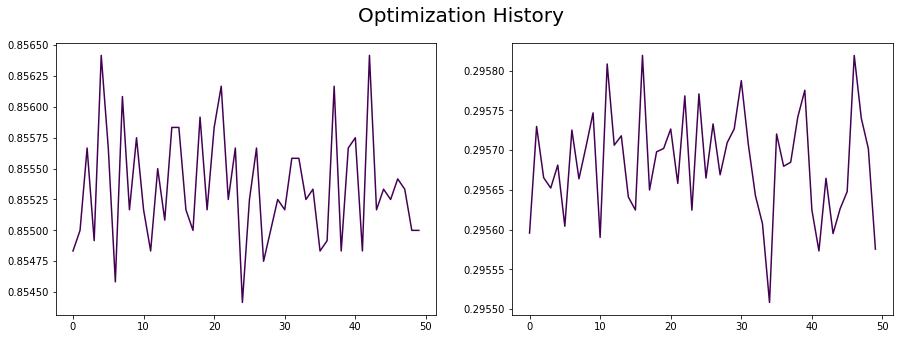

In [319]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history.history['accuracy'])
axs[1].plot(history.history['loss'])
fig.suptitle("Optimization History", fontsize=20)

In [20]:
# Set up training data and lables
data_out = np.concatenate([mdl_embed(dat) for dat in data_list], axis=0)
class_list = [np.array(len(cfg)*[i]) for i, cfg in enumerate(data_list)]
labels = np.concatenate(class_list, axis=0)
data_out.shape, labels.shape

((12000, 3), (12000,))

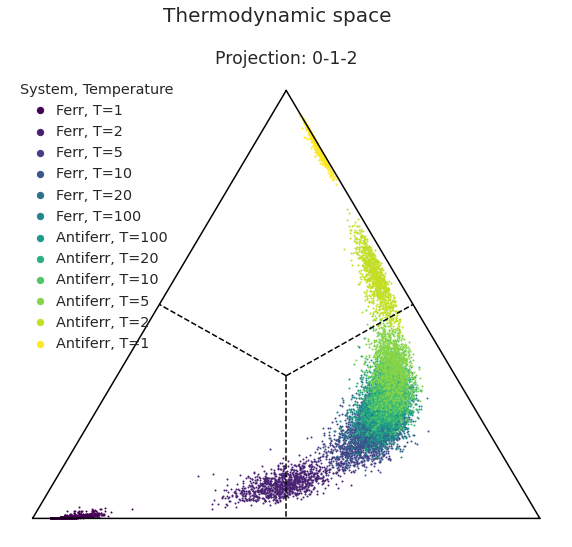

In [313]:
trslt = {'t':'Ferr', 'a':"Antiferr"}
cnames = [f'{trslt[t[0]]}, T={t[1:]}' for t in temps]
plot_ternary(data_out, labels, np.unique(labels), class_names = cnames, plt_title = "Thermodynamic space",
             size=10)

## 3. Learning and Predicting System Properties

Learn mapping between the trained embedding (thermodynamic) space and physical properties

### 3.1 System temperature

#### 3.1.1 Model and its training

In [117]:
def build_temp_layers(nunit):
    """Determine temperature of the system generating given configurations.
    
    Note that the effect of temperature is indistinguishable from the overall interaction strength.
    
    Arguments:
    ----------
    ndim: int
        dimension of the input embedding space 
        
    Returns:
    --------
    model: tensorflow model
        Model translating a vector in the thermodynamic space into temperature.
    """
    model = Sequential()
    model.add(Lambda(lambda x: tf.math.log(x)))
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Lambda(lambda x: tf.math.exp(x)))
    
    return model

In [119]:
def build_property_learn(mdl_embed, mdl_prop):
 
    mdl_embed.trainable = False

    # Build a complete model
    model = Sequential()
    model.add(mdl_embed)
    model.add(mdl_prop)

    return model

In [120]:
mdl_temp_layers = build_temp_layers(6)
mdl_temp = build_property_learn(mdl_embed, mdl_temp_layers)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 3)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 24        
_________________________________________________________________
activation_14 (Activation)   (None, 6)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 42        
_________________________________________________________________
activation_15 (Activation)   (None, 6)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 7         
_________________________________________________________________
lambda_6 (Lambda)            (None, 1)               

In [121]:
mdl_temp.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['MAE'], optimizer=Adam())

In [122]:
temp_list = [np.array(len(cfg)*[1/float(t[1:])]) for t, cfg in zip(temps, data_list)]
y_temp = np.concatenate(temp_list, axis=0)
y_temp.shape

(12000,)

In [123]:
history = mdl_temp.fit(data_train, y_temp, epochs=100, verbose=1)

Epoch 1/100
375/375 [==============================] - 1s 1ms/step - loss: 0.2941 - MAE: 0.4762
Epoch 2/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0170 - MAE: 0.1113
Epoch 3/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0077 - MAE: 0.0744
Epoch 4/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0064 - MAE: 0.0661
Epoch 5/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0058 - MAE: 0.0618
Epoch 6/100
375/375 [==============================] - 1s 1ms/step - loss: 0.0055 - MAE: 0.0594
Epoch 7/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0052 - MAE: 0.0574
Epoch 8/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0051 - MAE: 0.0570
Epoch 9/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0043 - MAE: 0.0528
Epoch 10/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0039 - MAE: 0.0494
Epoch 11/100
375/375 [=================

375/375 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0428
Epoch 86/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0429
Epoch 87/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0427
Epoch 88/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0419
Epoch 89/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0431
Epoch 90/100
375/375 [==============================] - 0s 954us/step - loss: 0.0032 - MAE: 0.0429
Epoch 91/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0033 - MAE: 0.0438
Epoch 92/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0423
Epoch 93/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0430
Epoch 94/100
375/375 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0431
Epoch 95/100
375/375 [===================

#### 3.1.2 Evaluation and predictions

In [290]:
y_pred = mdl_temp.predict(data_train)

Text(0.5, 1.0, 'Histograms of inverse temperatures: simulations vs. predictions')

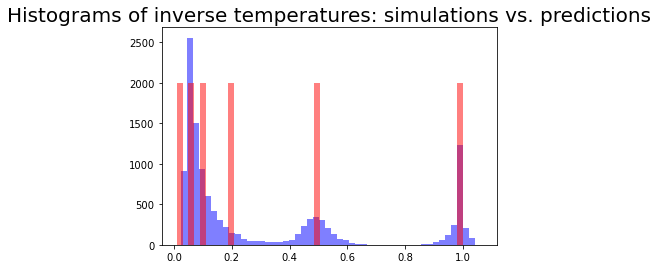

In [291]:
_ = plt.hist(np.ravel(y_pred), color='b', alpha=0.5, bins=50, label="Predicted")
_ = plt.hist(np.ravel(y_temp), color='r', alpha=0.5, bins=50, label="Simulated")
plt.title("Histograms of inverse temperatures: simulations vs. predictions", fontsize=20)

Text(0.5, 1.0, 'Predicted vs. simulated inverse temperature')

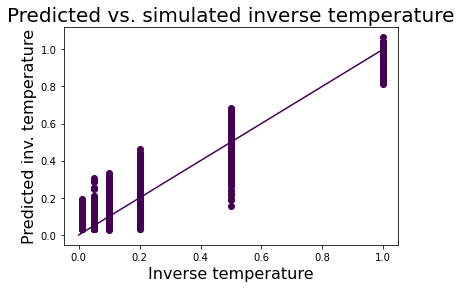

In [294]:
plt.scatter(np.ravel(y_temp), np.ravel(y_pred))
plt.plot([0, 1], [0, 1])
plt.xlabel("Inverse temperature", fontsize=16)
plt.ylabel("Predicted inv. temperature", fontsize=16)
plt.title("Predicted vs. simulated inverse temperature", fontsize=20)

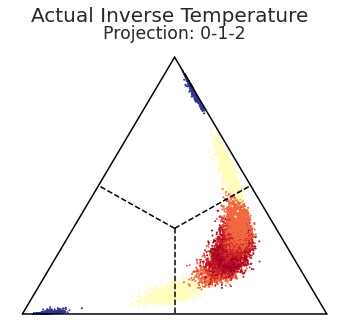

In [276]:
plot_ternary_continuum(data_out, np.ravel(y_temp), size=6, plt_title = "Actual Inverse Temperature")

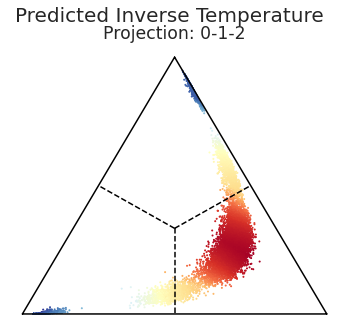

In [277]:
plot_ternary_continuum(data_out, np.ravel(y_pred), size=6, plt_title = "Predicted Inverse Temperature")

### 3.2 System type: Ferromagnetic vs. Antiferromagnetic

#### 3.2.1 Model and its training

In [180]:
def build_system_id_layers(ndim):
    """Classify configurations as coming from ferromagnetic or antiferromagnetic systems
        
    Note that the effect of temperature is indistinguishable from the overall interaction strength.
    
    Arguments:
    ----------
    ndim: int
        dimension of the input embedding space 
        
    Returns:
    --------
    model: tensorflow model
        Model translating a vector in the thermodynamic space into temperature.
    """
       
    model = Sequential()
    model.add(Lambda(lambda x: tf.math.log(x)))
    model.add(Dense(ndim))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [299]:
mdl_sysid_layers = build_system_id_layers(ndim = 4)
mdl_sysid = build_property_learn(mdl_embed, mdl_sysid_layers)

In [300]:
mdl_sysid.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=Adam())

In [301]:
sysid_list = [np.array(len(cfg)*[int(t[0] == "a")]) for t, cfg in zip(temps, data_list)]
y_sysid = np.concatenate(sysid_list, axis=0)
y_sysid = np.expand_dims(y_sysid, axis=-1)
y_sysid.shape

(12000, 1)

In [308]:
history = mdl_sysid.fit(data_train, y_sysid, epochs=50, verbose=1)

Epoch 1/50
375/375 [==============================] - 1s 1ms/step - loss: 0.2956 - acc: 0.8548
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 0.2957 - acc: 0.8550
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 0.2957 - acc: 0.8557
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 0.2957 - acc: 0.8549
Epoch 5/50
375/375 [==============================] - 1s 1ms/step - loss: 0.2957 - acc: 0.8564
Epoch 6/50
375/375 [==============================] - 0s 1ms/step - loss: 0.2956 - acc: 0.8557
Epoch 7/50
375/375 [==============================] - 0s 1ms/step - loss: 0.2957 - acc: 0.8546
Epoch 8/50
375/375 [==============================] - 0s 1ms/step - loss: 0.2957 - acc: 0.8561
Epoch 9/50
375/375 [==============================] - 0s 1ms/step - loss: 0.2957 - acc: 0.8552
Epoch 10/50
375/375 [==============================] - 0s 1ms/step - loss: 0.2957 - acc: 0.8558
Epoch 11/50
375/375 [============================

#### 3.2.2 Evaluation and predictions

In [309]:
# Predict categories: ferromagnetic vs. non-ferromagnetic
y_pred = (np.ravel(mdl_sysid.predict(data_train)) > 0.5).astype(np.int)

from sklearn.metrics import confusion_matrix
print("Confusion matrix")
confusion_matrix(np.ravel(y_sysid), np.ravel(y_pred))

Confusion matrix


array([[5139,  861],
       [ 876, 5124]])

In [310]:
correct = (np.ravel(y_sysid) != np.ravel(y_pred)).astype(np.int)

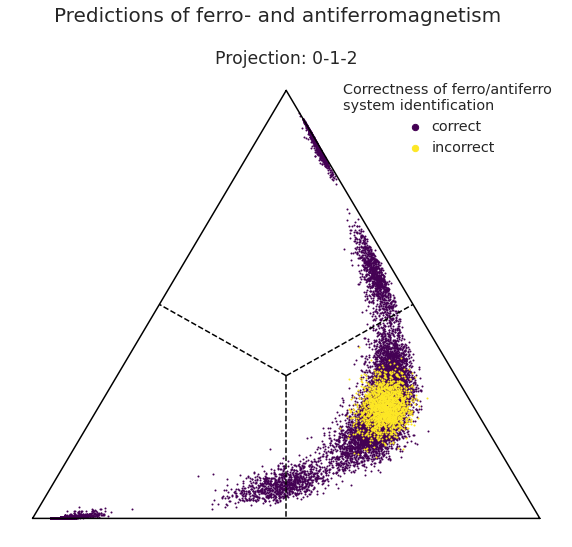

In [314]:
idx = np.random.permutation(len(correct))  # mix them a bit
plot_ternary(data_out[idx], correct[idx], np.unique(correct), class_names = ["correct", "incorrect"],
             size=10, plt_title = "Predictions of ferro- and antiferromagnetism",
             legend_title = "Correctness of ferro/antiferro\nsystem identification")